# TVA

In [2]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
from src.Coalition_Compromising import find_stable_coalitions_by_compromising
import os
import numpy as np 
import pandas as pd

In [3]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

This is the voting input

In [4]:
voting = utils.read_voting(path_voting, table_name="voting5")
voting_table = voting.to_pandas()
voting_table

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


(20, 30)
None


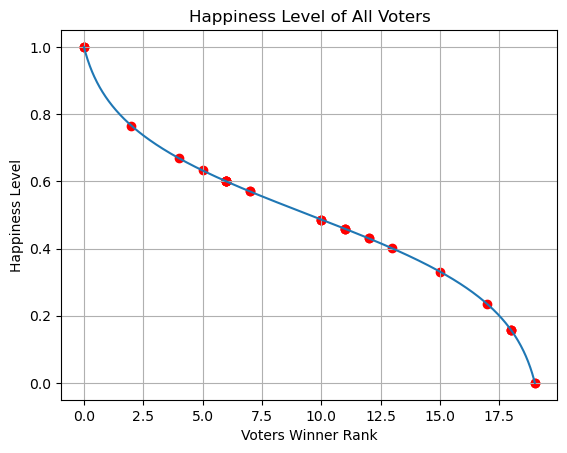

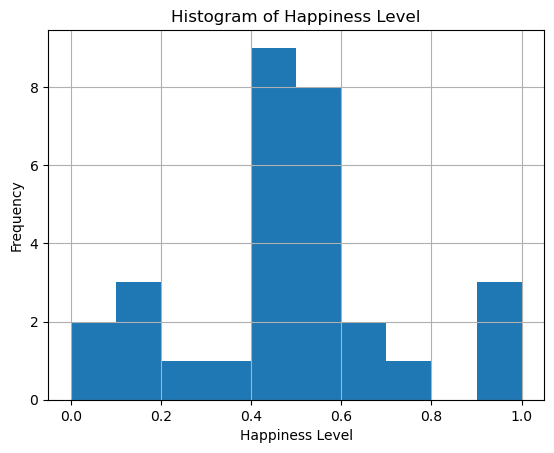

In [5]:
n_cand =20
random_voting = utils.random_voting(30, n_cand)
print(random_voting.shape)
result_random = plurality_outcome(random_voting)
hlevel = HappinessLevel(random_voting, result_random.winner)
print(hlevel._all_happiness_level)
hlevel.plot()
hlevel.histogram()

## Strategic Voting

In [6]:
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5
preference_0,C,B,C,C,B,A
preference_1,A,D,D,D,A,D
preference_2,D,C,A,B,D,B
preference_3,B,A,B,A,C,C


In [7]:
result = plurality_outcome(voting)
result

Winner: C
{'A': 1, 'B': 2, 'C': 3, 'D': 0}

Note that **voter 5** is the only voter that can engage in strategic voting. Voter 5 prefers $B$ over the winner $C$. Hence, they can increase their $\text{Happiness Level}$ by placing $B$ as their first preference, resulting in a tie between $C$ and $B$ in the voting outcome (for plurality, voting for two, Borda). Since ties are resolved in alphabetical order, $B$ wins over $C$.

The table below displays the two voting strategies available to voter 5.

In [8]:
happiness_level = HappinessLevel(voting, result.winner)
strategic_voting = StrategicVoting(voting).run(happiness_level, plurality_outcome)

strategic_voting.all

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487
1,5,"[B, D, A, C]",B,0.410487,0.0,2.820973,3.410487


The table displays the best strategic voting for each voter

In [9]:
strategic_voting.best

,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,"[B, A, D, C]",B,0.410487,0.0,2.820973,3.410487


Strategic Voting Risk

In [10]:
strategic_voting.risk

0.13682886358890622

# ADVANCED TVA Using Clustering + Compromising
The idea is to use Clustering plus Compromising. We try to find the stable coalitions that garantee an increase of happiness for all their partecipants

In [12]:
voting_df= pd.DataFrame(random_voting).T
coals= find_stable_coalitions_by_compromising(10, voting_df, hlevel, result_random)


0     0.458745
1     0.157123
2     0.400249
3     0.000000
4     0.599751
5     1.000000
6     0.486341
7     0.632303
8     0.430283
9     0.599751
10    1.000000
11    0.668792
12    0.458745
13    1.000000
14    0.486341
15    0.599751
16    0.157123
17    0.331208
18    0.157123
19    0.486341
20    0.000000
21    0.458745
22    0.569717
23    0.234424
24    0.765576
25    0.569717
26    0.430283
27    0.599751
28    0.599751
29    0.599751
Name: H, dtype: float64
Pushing J made everyone in the group 0 happier, here the new winner:   Winner: J
{'A': 1, 'B': 0, 'C': 3, 'D': 0, 'E': 2, 'F': 2, 'G': 1, 'H': 1, 'I': 0, 'J': 5, 'K': 0, 'L': 0, 'M': 2, 'N': 3, 'O': 2, 'P': 1, 'Q': 0, 'R': 2, 'S': 3, 'T': 2}
is it stable?
False
Pushing R made everyone in the group 2 happier, here the new winner:   Winner: R
{'A': 1, 'B': 0, 'C': 3, 'D': 0, 'E': 3, 'F': 2, 'G': 1, 'H': 1, 'I': 0, 'J': 1, 'K': 0, 'L': 1, 'M': 2, 'N': 3, 'O': 2, 'P': 1, 'Q': 1, 'R': 5, 'S': 1, 'T': 2}
is it stable?
False
Pu

In [1]:

for el in coals:
    if el[0]==True:

        print(el)

NameError: name 'coals' is not defined

In [13]:
'''
from scipy.stats import spearmanr
from sklearn.cluster import AgglomerativeClustering
from src import utils
from src.outcomes import plurality_outcome
from src.happiness_level import HappinessLevel
import numpy as np 
import pandas as pd
import hashlib
from itertools import combinations


def get_df_hash(df): 
    df_bytes = df.to_json().encode()
    return hashlib.md5(df_bytes).hexdigest()

def remove_elements_above_or_equal_index(lst, index): 
    if index < 0 or index >= len(lst):
        return lst  
    
    return lst[:index]  


def find_new_happiness(manipulations, coalition, voting_df): #Function that for a manipulation of a coalition gives you the new happiness values
    n_cand = len(voting_df.columns)-1
    coalition['manipulation']=manipulations
    indici = coalition.index
    df = pd.DataFrame(manipulations, index= indici, columns=[i for i in range(0, n_cand)])
    new_voting_df = voting_df.copy()
    new_voting_df.loc[indici] = df
    new_results = plurality_outcome(new_voting_df.iloc[:, :n_cand].values.T)
    diz = HappinessLevel(voting_df.iloc[:, :n_cand].values.T, new_results.winner).happiness_level_dict 
    New_Happiness_Levels = pd.DataFrame.from_dict(diz, orient='index', columns=['New_H']) #compute the happiness of the new results with respect of the real preferences
    coalition = pd.merge(coalition, New_Happiness_Levels,left_index=True, right_index=True)

    
    return coalition, new_results

def find_new_happiness2(manipulations, coalition, voting_df): #Function that for a manipulation of a coalition gives you the new happiness values
    n_cand = len(voting_df.columns)-1
    coalition['manipulation']=manipulations
    indici = coalition.index
    df = pd.DataFrame(manipulations, index= indici, columns=[i for i in range(0, n_cand)])
    new_voting_df = voting_df.copy()
    new_voting_df.loc[indici] = df
    new_results = plurality_outcome(new_voting_df.iloc[:, :n_cand].values.T)
    diz = HappinessLevel(voting_df.iloc[:, :n_cand].values.T, new_results.winner).happiness_level_dict 
    New_Happiness_Levels = pd.DataFrame.from_dict(diz, orient='index', columns=['New_H_subcoal']) #compute the happiness of the new results with respect of the real preferences
    coalition = pd.merge(coalition, New_Happiness_Levels,left_index=True, right_index=True)

    
    return coalition, new_results
def analyze_core(coalition, var1, var2): #Analize if inside or not the code
    

    real_happ = coalition[var1]
    fake_happ = coalition[var2]
    
    comparison_result = [fake > real for real, fake in zip(real_happ, fake_happ)]
    
    if all(comparison_result):
        return True
    else:
        return False


def stability_of_coalitions(coal, voting_df, results, scoal_index):
    
    combinations_list = []
    stable=True
    r=2
    max_r = len(coal.index)
    subcoalitions=[]
    while r<max_r:
        combinations_list.extend(list(combinations(coal.index, r)))
        for el in combinations_list:
            indice = pd.Index(el)
            new_poss_coal = coal.loc[indice]
            better_op=[]
            if get_df_hash(new_poss_coal.drop(columns=['H', 'New_H', 'gruppo'])) not in scoal_index:
                scoal_index[get_df_hash(new_poss_coal.drop(columns=['gruppo', 'New_H', 'H']))]=new_poss_coal

                for index, row in new_poss_coal.iterrows():
                    pref = list(row.iloc[0:-4])
                    ind = pref.index(results.winner) 
                    candidates = set(remove_elements_above_or_equal_index(pref, ind)) #find the candidates above the winner
                    better_op.append(candidates) 
            
                if len(better_op)>1: #if the coalition is bigg than 1
                    intersection = better_op[1].copy()
                    for el in better_op:
                        intersection = set.intersection(el, intersection)

                    if len(intersection)>0:

                        for alt in intersection: #try the alternatives in the intersection

                            man=[] #initialize the list with the voters manipulations 

                            for index, row in new_poss_coal.iterrows():
                                pref = list(row.iloc[0:-4])
                                ind = pref.index(alt)
                                pref.pop(ind)
                                pref.insert(0, alt)
                                man.append(pref) 
                            
                            coal_new_h, new_result = find_new_happiness2(man, new_poss_coal.iloc[:, :-1], voting_df) #compute the new happiness
                            
                            
                            if analyze_core(coal_new_h, 'H', 'New_H_subcoal') == True:
                                
                                
                                is_stable = pd.concat([coal_new_h, new_poss_coal['New_H']], axis=1)
                                
                                if analyze_core(is_stable, 'New_H', 'New_H_subcoal')==True:
                                    stable=False
                                    subcoalitions.append(is_stable)
                                   
            else:

                print('ciaooo')
                coal_new_h = scoal_index[get_df_hash(new_poss_coal.drop(columns=['H', 'New_H', 'gruppo']))]

                if analyze_core(coal_new_h, 'H', 'New_H_subcoal') == True:

                    is_stable = pd.concat([coal_new_h, new_poss_coal['New_H']], axis=1)
                    
                    if analyze_core(is_stable, 'New_H', 'New_H_subcoal')==True:
                        stable=False
                        subcoalitions.append(is_stable)

                        
        combinations_list=[]
        r+=1

    if len(subcoalitions)>0:
        return stable, subcoalitions
    else:

        return stable, [coal]
'''

"\nfrom scipy.stats import spearmanr\nfrom sklearn.cluster import AgglomerativeClustering\nfrom src import utils\nfrom src.outcomes import plurality_outcome\nfrom src.happiness_level import HappinessLevel\nimport numpy as np \nimport pandas as pd\nimport hashlib\nfrom itertools import combinations\n\n\ndef get_df_hash(df): \n    df_bytes = df.to_json().encode()\n    return hashlib.md5(df_bytes).hexdigest()\n\ndef remove_elements_above_or_equal_index(lst, index): \n    if index < 0 or index >= len(lst):\n        return lst  \n    \n    return lst[:index]  \n\n\ndef find_new_happiness(manipulations, coalition, voting_df): #Function that for a manipulation of a coalition gives you the new happiness values\n    n_cand = len(voting_df.columns)-1\n    coalition['manipulation']=manipulations\n    indici = coalition.index\n    df = pd.DataFrame(manipulations, index= indici, columns=[i for i in range(0, n_cand)])\n    new_voting_df = voting_df.copy()\n    new_voting_df.loc[indici] = df\n    new

In [14]:
'''
def find_stable_coalitions_by_compromising(max_coal, voting_df, happiness_level, results):
    
    win = results.winner
    voting_df['H']= happiness_level._all_happiness_level
    others = voting_df[voting_df[0]!=win]
    #Creating Dissimilarity Matrix
    rankings = np.array(others.T)
    cor_mat, _ = spearmanr(rankings[:-2])
    dsim_mat = np.around(1 - cor_mat, decimals=4)
    np.fill_diagonal(dsim_mat, 0)

    #find stable coalitions
    coal = []
    coal_index= {}
    scoal_index ={}
    for num in range(max_coal, 1, -1):

        clustering = AgglomerativeClustering(n_clusters=num, affinity='precomputed', linkage='average') #do clustering
        clusters = clustering.fit_predict(dsim_mat)
        others['gruppo'] = clusters

        for coal_id, coalition in others.groupby('gruppo'):
        
        
            
            if get_df_hash(coalition.iloc[:, :-2]) not in coal_index:
                better_op=[]
                coal_index[get_df_hash(coalition.iloc[:, :-2])]=coalition

                for index, row in coalition.iterrows():
                    pref = list(row.iloc[0:-2])
                    ind = pref.index(win) 
                    candidates = set(remove_elements_above_or_equal_index(pref, ind)) #find the candidates above the winner
                    better_op.append(candidates) 
            
                if len(better_op)>1: #if the coalition is bigg than 1
                    intersection = better_op[1].copy()
                    for el in better_op:
                        intersection = set.intersection(el, intersection)

                    if len(intersection)>0:

                        for alt in intersection: #try the alternatives in the intersection

                            man=[] #initialize the list with the voters manipulations 

                            for index, row in coalition.iterrows():
                                pref = list(row.iloc[0:-2])
                                ind = pref.index(alt)
                                pref.pop(ind)
                                pref.insert(0, alt)
                                man.append(pref) 

                            coal_new_h, new_result = find_new_happiness(man, coalition, voting_df) #compute the new happiness

                            coalition = coalition.iloc[:, :-1]

                            if analyze_core(coal_new_h, 'H', 'New_H') == True:

                                #print(f'Pushing {alt} made everyone in the group {coal_id} happier, here the new winner:  ', new_result)
                                print(f'is it stable?')
                                stable, subcoals = stability_of_coalitions(coal_new_h, voting_df, results, scoal_index)
                                print(stable)
                                if stable==True:

                                    coal.append((True, coal_new_h, new_result))
                                else:

                                    coal.append((False, coal_new_h, new_result, subcoals))

                                


    return coal

'''

"\ndef find_stable_coalitions_by_compromising(max_coal, voting_df, happiness_level, results):\n    \n    win = results.winner\n    voting_df['H']= happiness_level._all_happiness_level\n    others = voting_df[voting_df[0]!=win]\n    #Creating Dissimilarity Matrix\n    rankings = np.array(others.T)\n    cor_mat, _ = spearmanr(rankings[:-2])\n    dsim_mat = np.around(1 - cor_mat, decimals=4)\n    np.fill_diagonal(dsim_mat, 0)\n\n    #find stable coalitions\n    coal = []\n    coal_index= {}\n    scoal_index ={}\n    for num in range(max_coal, 1, -1):\n\n        clustering = AgglomerativeClustering(n_clusters=num, affinity='precomputed', linkage='average') #do clustering\n        clusters = clustering.fit_predict(dsim_mat)\n        others['gruppo'] = clusters\n\n        for coal_id, coalition in others.groupby('gruppo'):\n        \n        \n            \n            if get_df_hash(coalition.iloc[:, :-2]) not in coal_index:\n                better_op=[]\n                coal_index[get_df_h